In [1]:
%load_ext autoreload
%autoreload all

import torch

from gem import MiniFranceDataset
from torch.utils.data import DataLoader, random_split

n_tiles = 4 
dir_path = '/GEM/data/MiniFrance/'
dataset = MiniFranceDataset(dir_path, n_tiles=n_tiles, dataset_type='labeled_train')

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_set, batch_size=2, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=2, shuffle=True, num_workers=1)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


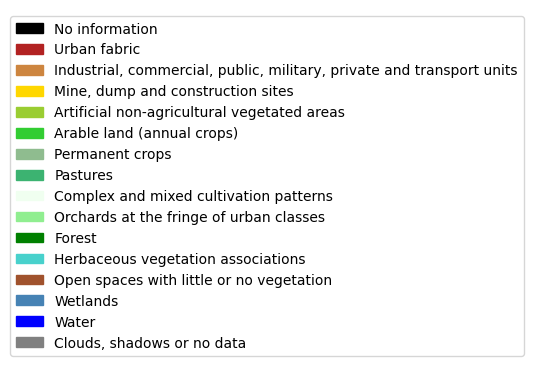

In [2]:
from typing import Any
import matplotlib.colors as mcolors

class_attributes: list[tuple[str, Any]] = [
    ("No information", mcolors.CSS4_COLORS['black']),
    ("Urban fabric", mcolors.CSS4_COLORS['firebrick']),
    ('Industrial, commercial, public, military, private and transport units', mcolors.CSS4_COLORS['peru']),
    ("Mine, dump and construction sites", mcolors.CSS4_COLORS['gold']),
    ("Artificial non-agricultural vegetated areas", mcolors.CSS4_COLORS['yellowgreen']),
    ("Arable land (annual crops)", mcolors.CSS4_COLORS['limegreen']),
    ("Permanent crops", mcolors.CSS4_COLORS['darkseagreen']),
    ("Pastures", mcolors.CSS4_COLORS['mediumseagreen']),
    ("Complex and mixed cultivation patterns", mcolors.CSS4_COLORS['honeydew']),
    ("Orchards at the fringe of urban classes", mcolors.CSS4_COLORS['lightgreen']),
    ("Forest", mcolors.CSS4_COLORS['green']),
    ("Herbaceous vegetation associations", mcolors.CSS4_COLORS['mediumturquoise']),
    ("Open spaces with little or no vegetation", mcolors.CSS4_COLORS['sienna']),
    ('Wetlands', mcolors.CSS4_COLORS['steelblue']),
    ("Water", mcolors.CSS4_COLORS['blue']),
    ("Clouds, shadows or no data", mcolors.CSS4_COLORS['gray']),
]

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

handles = [Patch(color=c, label=l) for l, c in class_attributes]
plt.legend(handles=handles)
plt.gca().set_axis_off()
plt.show()

In [4]:
from gem.model import SegNet
from torch.nn.functional import one_hot
from torchvision.transforms import transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

tile_size = dataset.get_tile_size()
model = SegNet(features=64, out_channels=len(class_attributes))
model.to(device)

def get_inputs(data):
    normalize = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor(),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    if len(data['image'].shape) == 4:
        inputs = [normalize(image) for image in data['image']]
        inputs = torch.stack(inputs).float()
    else:
        inputs = normalize(data['image']).unsqueeze(0)

    return inputs

def get_labels(data):
    if len(data['landcover_map'].shape) == 4:
        labels = [image for image in data['landcover_map']]
        labels = torch.stack(labels)
    else:
        labels = data['landcover_map']

    labels = one_hot(labels.long(), num_classes=len(class_attributes))
    labels = labels.squeeze(1).permute(0, 3, 1, 2).float()

    return labels


def train_one_epoch(optimizer, loss_fn, epoch_index: int, tb_writer: SummaryWriter):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(tqdm(train_loader)):
        inputs = get_inputs(data).to(device)
        labels = get_labels(data).to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

        print_step = 100
        if i % print_step == print_step - 1:
            last_loss = running_loss / print_step
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.0

    return last_loss


In [6]:
from datetime import datetime

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('/GEM/runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(optimizer, loss_fn, epoch_number, writer)

    running_vloss = 0.0
    model.eval()

    i = 0
    with torch.no_grad():
        for i, data in enumerate(tqdm(test_loader)):
            inputs = get_inputs(data).to(device)
            labels = get_labels(data).to(device)

            outputs = model(inputs)
            vloss = loss_fn(outputs, labels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)

    writer.add_scalars('Training vs. Validation Loss',
                       {'Training' : avg_loss, 'Validation' : avg_vloss},
                       epoch_number + 1)
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_dir = '/GEM/models/'
        model_name = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_dir + model_name)

    epoch_number += 1

In [7]:
from gem.model import SegNet
import numpy as np
import matplotlib.pyplot as plt


def plot_preds(dataset, model, data_range: tuple[int, int]):
    class_color_lut = np.array([mcolors.hex2color(color) for _, color in class_attributes]) * 255

    for i in range(*data_range):
        data = dataset[i]
        image = data['image']
        label = data['landcover_map']

        inputs = get_inputs(data).to(device)
        pred = model(inputs)

        # Plot the image
        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze().cpu().int().numpy().transpose(1, 2, 0))
        plt.title('Image')
        plt.axis('off')

        # Plot the prediction
        plt.subplot(1, 3, 2)
        pred_img = pred.squeeze().argmax(dim=0).cpu().numpy()
        pred_img = class_color_lut[pred_img]
        plt.imshow(pred_img.astype(np.uint8))
        plt.title('Prediction')
        plt.axis('off')

        # Plot the label
        plt.subplot(1, 3, 3)
        label_img = label.squeeze().cpu().numpy()
        label_img = class_color_lut[label_img]
        plt.imshow(label_img.astype(np.uint8))
        plt.title('Label')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

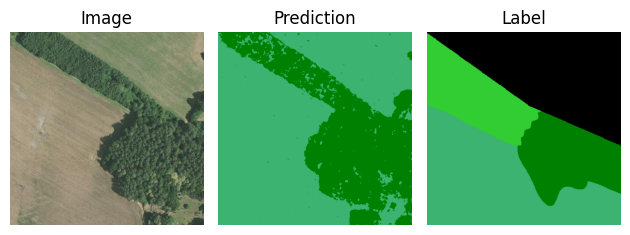

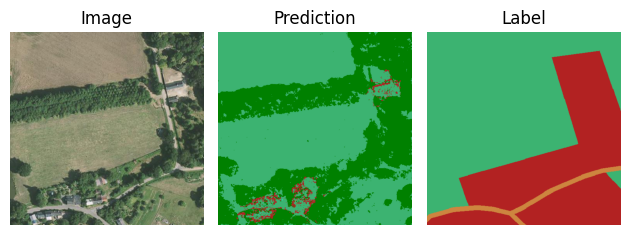

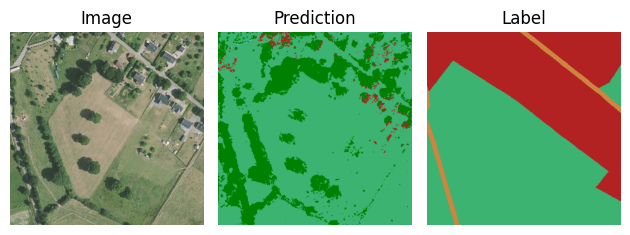

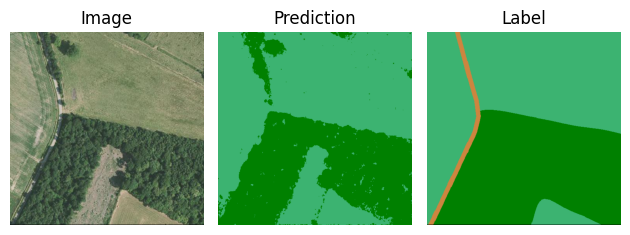

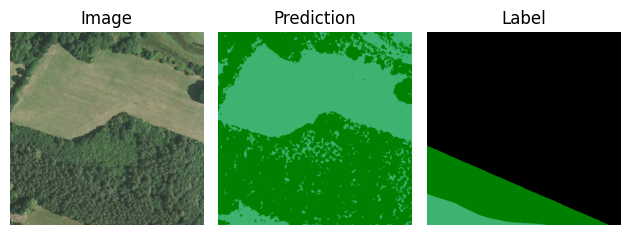

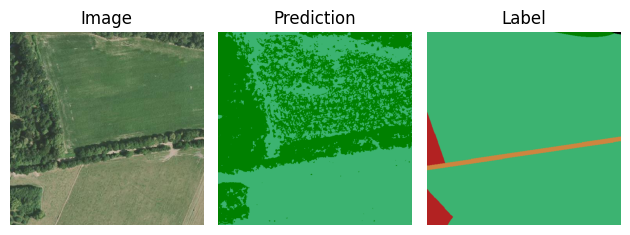

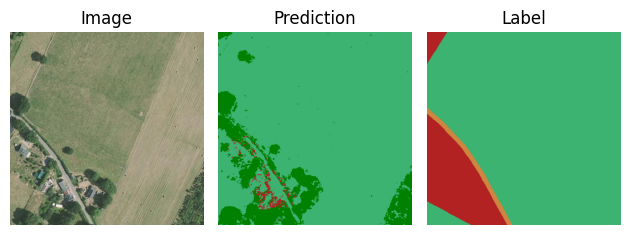

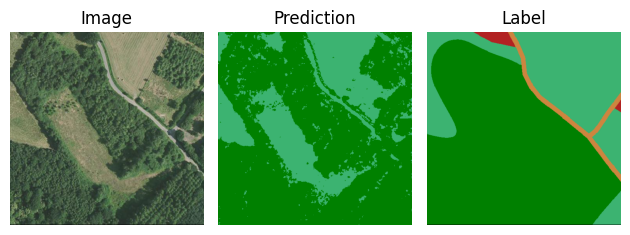

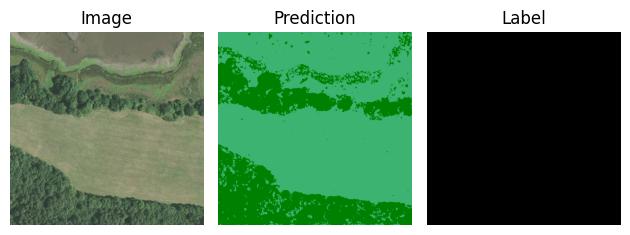

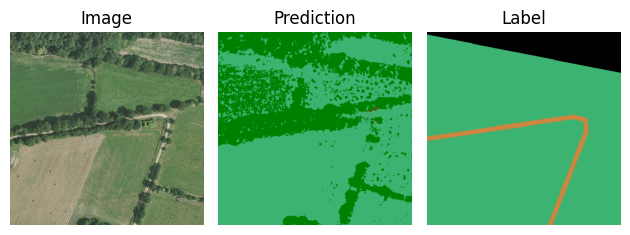

In [8]:
trained_model = SegNet(features=64, out_channels=len(class_attributes))
trained_model.load_state_dict(torch.load('/GEM/models/model_20240421_164848_1'))
trained_model.to(device)
trained_model.eval()
plot_preds(dataset, trained_model, (100, 110))